# Data Quality Check — IBOV Top40 Features

Este notebook valida se o dataset gerado em `data/processed/ibov_top40_features.(parquet|csv)` foi carregado corretamente e se está adequado para treinar um modelo direcional (alta/queda) semanal/mensal.

Checklist:

- Arquivo existe e carrega
- Tipos e datas ok
- Sem duplicatas (date, ticker)
- Cobertura por ticker e intervalos de datas
- NaNs controlados em features
- Targets (`target_w`, `target_m`) com distribuição razoável
- Dataset pronto para split temporal


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)

PARQUET_PATH = "../data/processed/ibov_top40_features.parquet"
CSV_PATH = "../data/processed/ibov_top40_features.csv"

def load_dataset():
    if os.path.exists(PARQUET_PATH):
        df_ = pd.read_parquet(PARQUET_PATH)
        source_ = PARQUET_PATH
    elif os.path.exists(CSV_PATH):
        df_ = pd.read_csv(CSV_PATH)
        source_ = CSV_PATH
    else:
        raise FileNotFoundError(
            "Não encontrei o arquivo processado. Rode: python -m src.features"
        )
    return df_, source_

df, source = load_dataset()

print("Fonte:", source)
print("Shape:", df.shape)
df.head()


Fonte: ../data/processed/ibov_top40_features.parquet
Shape: (176097, 38)


,date,ticker,open,high,low,close,volume,adjustedClose,adj_close,ret_1d,logret_1d,mom_5d,mom_21d,mom_63d,mom_126d,mom_252d,ma_10,price_to_ma_10,ma_21,price_to_ma_21,ma_63,price_to_ma_63,ma_126,price_to_ma_126,ma_252,price_to_ma_252,vol_10,vol_21,vol_63,logvol,logvol_z_63,hl_range,oc_change,rsi_14,future_ret_w,target_w,future_ret_m,target_m
0,2000-02-02 03:00:00,AXIA3,16.2500,16.3500,15.8500,16.2500,326300000,14.4289,14.4289,0.012462,0.012385,-0.084507,-0.166879,NaN,NaN,NaN,15.18318,-0.049679,15.963519,-0.096133,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.028987,NaN,19.603328,NaN,0.031546,0.000000,19.308257,0.055382,1,-0.071080,0
1,2000-02-02 03:00:00,AXIA6,17.7000,17.7500,17.3000,17.5000,457300000,16.2593,16.2593,0.008641,0.008604,-0.095610,-0.166472,NaN,NaN,NaN,17.41050,-0.066121,18.332129,-0.113071,NaN,NaN,NaN,NaN,NaN,NaN,0.021480,0.027161,NaN,19.940850,NaN,0.026012,-0.011299,15.816537,0.057143,1,-0.087138,0
2,2000-02-02 03:00:00,BBAS3,1.3167,1.3167,1.2867,1.2867,14100000,0.3986,0.3986,-0.022800,-0.023064,-0.061013,-0.058573,NaN,NaN,NaN,0.41718,-0.044537,0.417329,-0.044877,NaN,NaN,NaN,NaN,NaN,NaN,0.012518,0.020896,NaN,16.461685,NaN,0.023315,-0.022784,18.317530,0.042900,1,-0.049172,0
3,2000-02-02 03:00:00,BBDC3,7.7066,7.9201,7.6446,7.9201,105200000,3.7456,3.7456,0.044506,0.043544,0.055039,0.045439,NaN,NaN,NaN,3.71762,0.007526,3.680652,0.017646,NaN,NaN,NaN,NaN,NaN,NaN,0.042338,0.047703,NaN,18.471374,NaN,0.036039,0.027704,33.837080,-0.017380,0,-0.112158,0
4,2000-02-02 03:00:00,BBDC4,12.5165,12.8691,12.4284,12.6047,2251300000,5.9648,5.9648,0.019973,0.019776,0.005631,0.021422,NaN,NaN,NaN,6.15084,-0.030246,6.084781,-0.019718,NaN,NaN,NaN,NaN,NaN,NaN,0.043213,0.049138,NaN,21.534774,NaN,0.035459,0.007047,32.964054,0.048954,1,-0.013982,0


In [2]:
required_cols = {
    "date", "ticker", "open", "high", "low", "close", "volume",
    "adj_close", "ret_1d", "logret_1d",
    "target_w", "target_m"
}

missing = required_cols - set(df.columns)
print("Colunas faltando:", missing)

if not np.issubdtype(df["date"].dtype, np.datetime64):
    df["date"] = pd.to_datetime(df["date"], errors="coerce")

print("\nResumo date:")
print("min:", df["date"].min())
print("max:", df["date"].max())
print("datas nulas:", df["date"].isna().sum())

print("\nTipos:")
df.dtypes.head(30)


Colunas faltando: set()

Resumo date:
min: 2000-02-02 03:00:00
max: 2026-02-18 03:00:00
datas nulas: 0

Tipos:


date               datetime64[us]
ticker                        str
open                      float64
high                      float64
low                       float64
close                     float64
volume                      int64
adjustedClose             float64
adj_close                 float64
ret_1d                    float64
logret_1d                 float64
mom_5d                    float64
mom_21d                   float64
mom_63d                   float64
mom_126d                  float64
mom_252d                  float64
ma_10                     float64
price_to_ma_10            float64
ma_21                     float64
price_to_ma_21            float64
ma_63                     float64
price_to_ma_63            float64
ma_126                    float64
price_to_ma_126           float64
ma_252                    float64
price_to_ma_252           float64
vol_10                    float64
vol_21                    float64
vol_63                    float64
logvol        

In [3]:
dups = df.duplicated(subset=["date", "ticker"]).sum()
print("Duplicatas (date, ticker):", dups)

if dups > 0:
    df[df.duplicated(subset=["date", "ticker"], keep=False)].sort_values(["ticker", "date"]).head(20)


Duplicatas (date, ticker): 0


Tickers únicos: 38


,n_rows,start,end
ticker,,,
ALOS3,556,2023-11-27 03:00:00,2026-02-18 03:00:00
VBBR3,1057,2021-11-24 03:00:00,2026-02-18 03:00:00
TIMS3,1311,2020-11-12 03:00:00,2026-02-18 03:00:00
BPAC11,2191,2017-03-28 03:00:00,2026-02-18 03:00:00
RAIL3,2198,2017-04-11 03:00:00,2026-02-18 03:00:00
PRIO3,2620,2015-07-28 03:00:00,2026-02-18 03:00:00
ENEV3,2623,2013-11-22 03:00:00,2026-02-18 03:00:00
KLBN11,2973,2014-02-21 03:00:00,2026-02-18 03:00:00
BBSE3,3157,2013-05-29 03:00:00,2026-02-18 03:00:00


,n_rows,start,end
ticker,,,
EMBJ3,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
CMIG4,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
AXIA6,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
AXIA3,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
SBSP3,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
ITSA4,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
PETR3,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
PETR4,6455,2000-02-02 03:00:00,2026-02-18 03:00:00
BBDC4,6455,2000-02-02 03:00:00,2026-02-18 03:00:00


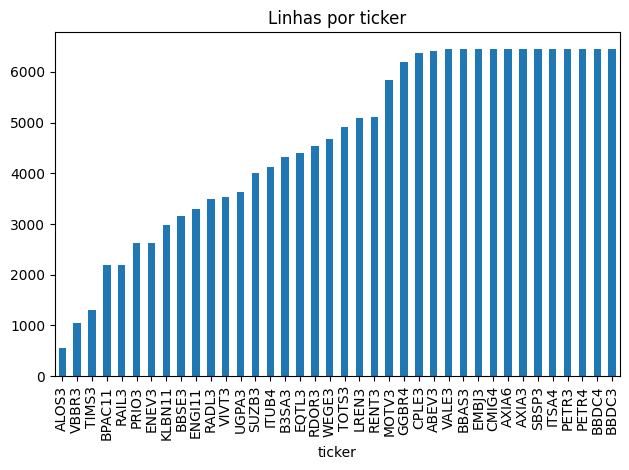

In [4]:
tickers = df["ticker"].nunique()
print("Tickers únicos:", tickers)

per_ticker = df.groupby("ticker").agg(
    n_rows=("date", "size"),
    start=("date", "min"),
    end=("date", "max")
).sort_values("n_rows")

display(per_ticker.head(10))
display(per_ticker.tail(10))

plt.figure()
per_ticker["n_rows"].plot(kind="bar")
plt.title("Linhas por ticker")
plt.tight_layout()
plt.show()


In [5]:
nan_ratio = (df.isna().mean() * 100).sort_values(ascending=False)
nan_ratio.head(30)


mom_252d           4.984753
price_to_ma_252    4.963174
ma_252             4.963174
mom_126d           2.265797
price_to_ma_126    2.244218
ma_126             2.244218
mom_63d            0.906319
vol_63             0.906319
price_to_ma_63     0.884740
ma_63              0.884740
logvol_z_63        0.884740
future_ret_m       0.453159
future_ret_w       0.107895
date               0.000000
close              0.000000
low                0.000000
high               0.000000
open               0.000000
ticker             0.000000
volume             0.000000
adj_close          0.000000
adjustedClose      0.000000
ma_21              0.000000
price_to_ma_21     0.000000
ma_10              0.000000
price_to_ma_10     0.000000
ret_1d             0.000000
logret_1d          0.000000
mom_5d             0.000000
mom_21d            0.000000
dtype: float64

== target_w ==
n válido: 176097
pct 1: 52.3393357070251
pct 0: 47.6606642929749
classe majoritária: 1
baseline acc: 0.523393357070251

== target_m ==
n válido: 176097
pct 1: 55.3859520605121
pct 0: 44.6140479394879
classe majoritária: 1
baseline acc: 0.553859520605121



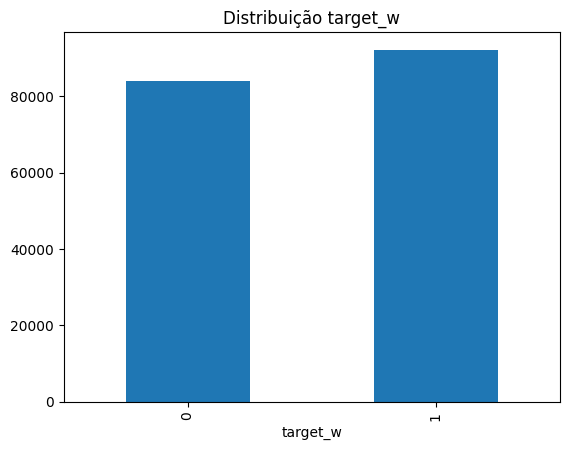

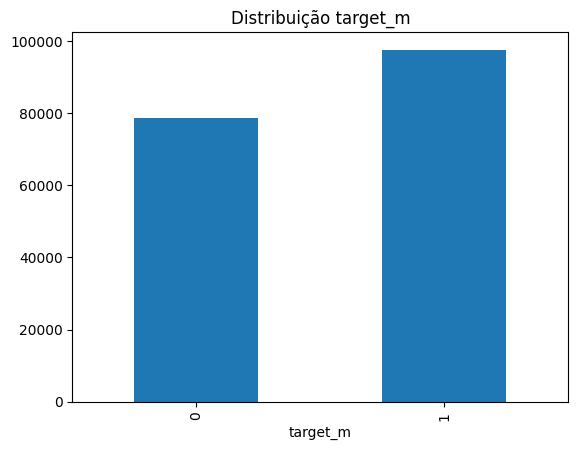

In [6]:
def target_stats(col):
    if col not in df.columns:
        print(f"{col} não existe")
        return
    
    s = df[col].dropna()
    print(f"== {col} ==")
    print("n válido:", len(s))
    print("pct 1:", (s == 1).mean() * 100)
    print("pct 0:", (s == 0).mean() * 100)
    
    maj = int(s.mode().iloc[0])
    baseline_acc = (s == maj).mean()
    print("classe majoritária:", maj)
    print("baseline acc:", baseline_acc)
    print()

target_stats("target_w")
target_stats("target_m")

plt.figure()
df["target_w"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição target_w")
plt.show()

plt.figure()
df["target_m"].dropna().astype(int).value_counts().sort_index().plot(kind="bar")
plt.title("Distribuição target_m")
plt.show()


In [7]:
valid_w = df.dropna(subset=["target_w"])
valid_m = df.dropna(subset=["target_m"])

print("Semanal válido:", len(valid_w))
print("Mensal válido:", len(valid_m))

bad_order = 0
for t, g in df.groupby("ticker"):
    if not g["date"].is_monotonic_increasing:
        bad_order += 1

print("Tickers com datas fora de ordem:", bad_order)

leak_cols = [c for c in df.columns if c.startswith("future_ret_")]
print("Colunas de retorno futuro presentes:", leak_cols)


Semanal válido: 176097
Mensal válido: 176097
Tickers com datas fora de ordem: 0
Colunas de retorno futuro presentes: ['future_ret_w', 'future_ret_m']


## O que considerar adequado para treinar?

Você quer ver:

- Duplicatas = 0
- ~40 tickers
- Poucos NaNs nas features principais
- Targets não extremamente desbalanceados (ideal 40/60 ou 45/55)
- Baseline accuracy não muito alto

Se tudo estiver consistente, podemos ir para:

➡️ Split temporal  
➡️ Modelo baseline (Logistic Regression)  
➡️ Métricas (AUC, F1)  
➡️ Backtest simples
